In [1]:
import numpy as np
import pandas as pd
import cv2
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import classification_report, confusion_matrix
import warnings

In [2]:
warnings.filterwarnings("ignore")

# # Training Data
train_dir = Path(r'C:\Users\shrir\OneDrive\Desktop\V sem\deep learning\DL project\train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

# Test Data
test_dir = Path(r'C:\Users\shrir\OneDrive\Desktop\V sem\deep learning\DL project\test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

val_dir = Path(r'C:\Users\shrir\OneDrive\Desktop\V sem\deep learning\DL project\validation')
val_filepaths = list(val_dir.glob(r'**/*.jpg'))

In [3]:
def image_processing(filepath):
    # Create a DataFrame with the filepath and the labels of the pictures

    labels = [str(filepath[i]).split("\\")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

In [29]:
train_df = image_processing(train_filepaths)
test_df = image_processing(test_filepaths)
val_df = image_processing(val_filepaths)
print("Training Set")
print("Number of Pictures: ",train_df.shape[0])
print("Number of Crops: ", len(train_df.Label.unique()))
l = sorted(list(train_df.Label.unique()))
print("Labels: ",l)

Training Set
Number of Pictures:  2830
Number of Crops:  36
Labels:  ['apple', 'banana', 'beetroot', 'bell pepper', 'cabbage', 'capsicum', 'carrot', 'cauliflower', 'chilli pepper', 'corn', 'cucumber', 'eggplant', 'garlic', 'ginger', 'grapes', 'jalepeno', 'kiwi', 'lemon', 'lettuce', 'mango', 'onion', 'orange', 'paprika', 'pear', 'peas', 'pineapple', 'pomegranate', 'potato', 'raddish', 'soy beans', 'spinach', 'sweetcorn', 'sweetpotato', 'tomato', 'turnip', 'watermelon']


    index                                           Filepath          Label
0       0  C:\Users\shrir\OneDrive\Desktop\V sem\deep lea...  chilli pepper
1       1  C:\Users\shrir\OneDrive\Desktop\V sem\deep lea...        lettuce
2       2  C:\Users\shrir\OneDrive\Desktop\V sem\deep lea...    bell pepper
3       3  C:\Users\shrir\OneDrive\Desktop\V sem\deep lea...       cucumber
4       4  C:\Users\shrir\OneDrive\Desktop\V sem\deep lea...           corn
5       6  C:\Users\shrir\OneDrive\Desktop\V sem\deep lea...         grapes
6       7  C:\Users\shrir\OneDrive\Desktop\V sem\deep lea...      soy beans
7       8  C:\Users\shrir\OneDrive\Desktop\V sem\deep lea...          onion
8       9  C:\Users\shrir\OneDrive\Desktop\V sem\deep lea...          mango
9      11  C:\Users\shrir\OneDrive\Desktop\V sem\deep lea...         carrot
10     14  C:\Users\shrir\OneDrive\Desktop\V sem\deep lea...           pear
11     15  C:\Users\shrir\OneDrive\Desktop\V sem\deep lea...       beetroot
12     16  C

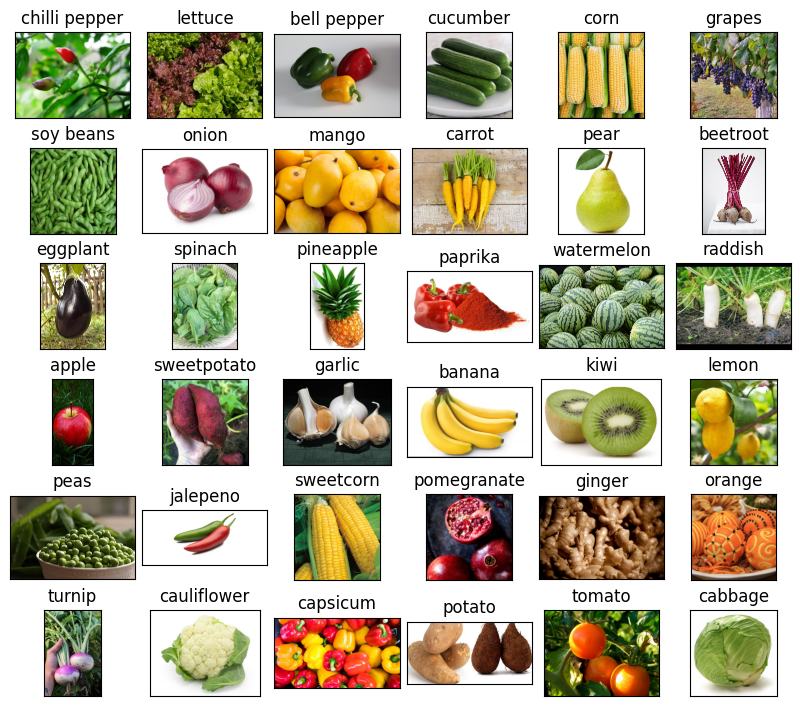

In [30]:
train_df.head(5)

# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()
print(df_unique)
# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [10]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [11]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 2830 validated image filenames belonging to 36 classes.


In [12]:
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 340 validated image filenames belonging to 36 classes.


In [14]:
val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 340 validated image filenames belonging to 36 classes.


In [15]:
model = tf.keras.Sequential([
    # tf.keras.layers.Resizing(IMG_SIZE, IMG_SIZE),
    # tf.keras.layers.Rescaling(1./255)
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='sigmoid'),
    tf.keras.layers.Dense(36, activation='softmax')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [16]:
import time

training_times = []
for epoch in range(5):
    start_time = time.time()
    history = model.fit(
        train_images,
        validation_data=val_images,
        batch_size=32,
        epochs=1,
        verbose=1
    )
    end_time = time.time()
    training_times.append(end_time - start_time)

89/89 [==============================] - 124s 1s/step - loss: 3.5954 - accuracy: 0.0283 - val_loss: 3.5935 - val_accuracy: 0.0294


If needed save the Model to run below cell

In [17]:
model.save("DLproject.h5")

In [23]:
pred = model.predict(test_images)
pred = np.argmax(pred, axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v, k) for k, v in labels.items())
pred1 = [labels[k] for k in pred]

11/11 [==============================] - 19s 2s/step


In [ ]:
labels

In [37]:
image_path = r"C:\Users\shrir\OneDrive\Desktop\V sem\deep learning\DL project\train\cucumber\Image_2.jpg"
img = cv2.imread(image_path)
img = cv2.resize(img,(224,224))
img_array = img.astype(np.float32) / 255.0 
img_array = np.expand_dims(img_array, axis=0)
predictions = model.predict(img_array)
print(labels)
print(labels[np.argmax(predictions)])
predictions

1/1 [==============================] - 0s 46ms/step
{0: 'apple', 1: 'banana', 2: 'beetroot', 3: 'bell pepper', 4: 'cabbage', 5: 'capsicum', 6: 'carrot', 7: 'cauliflower', 8: 'chilli pepper', 9: 'corn', 10: 'cucumber', 11: 'eggplant', 12: 'garlic', 13: 'ginger', 14: 'grapes', 15: 'jalepeno', 16: 'kiwi', 17: 'lemon', 18: 'lettuce', 19: 'mango', 20: 'onion', 21: 'orange', 22: 'paprika', 23: 'pear', 24: 'peas', 25: 'pineapple', 26: 'pomegranate', 27: 'potato', 28: 'raddish', 29: 'soy beans', 30: 'spinach', 31: 'sweetcorn', 32: 'sweetpotato', 33: 'tomato', 34: 'turnip', 35: 'watermelon'}
spinach


array([[0.01991514, 0.02296124, 0.02783719, 0.0313751 , 0.03298993,
        0.02889902, 0.02638076, 0.02303842, 0.02730038, 0.03075783,
        0.03391998, 0.02721158, 0.03283957, 0.02211898, 0.02772786,
        0.03268435, 0.02886129, 0.02272769, 0.03160071, 0.02557328,
        0.03287399, 0.02046979, 0.0276958 , 0.02479745, 0.02904932,
        0.02562947, 0.02420698, 0.02308316, 0.02936468, 0.03172216,
        0.03604237, 0.02562538, 0.02517669, 0.02052171, 0.03583072,
        0.03119003]], dtype=float32)